# certifciate_quality_classifier_v4
## I will be trying to add an additional outcome in this version to either Approve, Reject or Needs Review category - using Use binary logistic + calculated thresholds (ex:0.4/0.6 bands, will use scatter plot to check where its falling and add this band that needs review)

* Importing Wine dataset and converting into a certificate decision data
* build a model using linear and logistic regression
* find optimal threshold
* find confusion matrix to decide boundaries
* plot thresolds and plot of data points
* finally mark the acccuracy

In [95]:
import pandas as pd
import numpy as np
wine_df = pd.read_csv('../ref_datasets/winequality-red.csv',sep=';')
print(wine_df.head())
wine_df['decision'] = np.where(wine_df['quality'] > 5.5, 1, 0)
print(wine_df.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

In [96]:
#import all required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# load the data into X and y

X = wine_df[
    [
        "fixed acidity",
        "volatile acidity",
        "citric acid",
        "residual sugar",
        "chlorides",
        "free sulfur dioxide",
        "total sulfur dioxide",
        "density",
        "pH",
        "sulphates",
        "alcohol",
    ]
]
y = wine_df["decision"]  # original data only has two deicisons 0=Reject, 1=Approve

# Stratified split ensures balanced class representation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

# train the model
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear"),
)
model.fit(X_train, y_train)

# predict probability
p = model.predict_proba(X_test)[:, 1]  

# ROC-based optimal threshold
fpr, tpr, thresholds = roc_curve(y_test, p)
youden_index = np.argmax(tpr - fpr)
optimal_thresh = thresholds[youden_index]

#percentiles based threshold
low_thresh = np.percentile(p, 40)
high_thresh = np.percentile(p, 60)

print(f"Optimal ROC threshold: {optimal_thresh:.3f}")
print(f"Percentile thresholds: Reject<{low_thresh:.3f}, Approve>{high_thresh:.3f}")

# Apply thresholds
decision = np.select(
    [
        p <= low_thresh,  # Reject
        (p > low_thresh) & (p < high_thresh),  # Review
        p >= high_thresh,  # Approve
    ],
    [0, 1, 2],
)

# accuracy and confision matrix
decided_mask = decision != 1  # Exclude review zone for accuracy
decided_accuracy = accuracy_score(
    y_test[decided_mask], np.where(decision[decided_mask] == 2, 1, 0)
)
review_rate = np.mean(decision == 1)

print(f"\nAccuracy on decided cases: {decided_accuracy:.2f}")
print(f"Review rate: {review_rate:.2f}")

#save results
results_df = pd.DataFrame(
    {
        "probability": p,
        "true_label": y_test.values,
        "decision": decision,
    }
)
results_df.to_csv("wine_decision_results.csv", index=False)
print("Results saved to 'wine_decision_results.csv'")



Optimal ROC threshold: 0.515
Percentile thresholds: Reject<0.400, Approve>0.623

Accuracy on decided cases: 0.78
Review rate: 0.20
Results saved to 'wine_decision_results.csv'


We could achieve accuracy aligning with actual deicisons around 78%, but we also have 20% of deicision under review. 
which mean these fall under review zone. lets try creating confusion matrix to dine Type1 and Type2 errors 

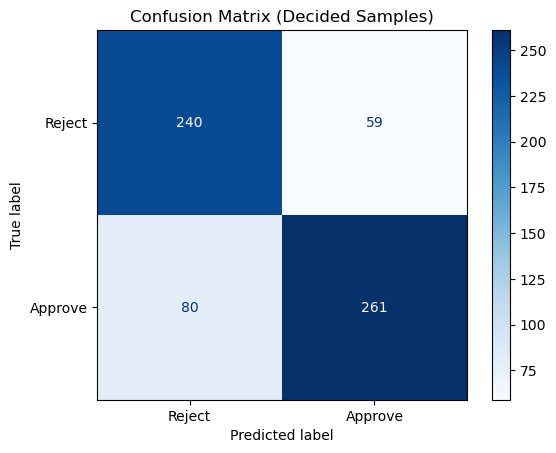

In [97]:
# Confusion matrix 
cm = confusion_matrix(
    y_test[decided_mask], np.where(decision[decided_mask] == 2, 1, 0)
)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Reject", "Approve"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Decided Samples)")
plt.show()


With above confusion matrix, we could see 59 wrong approvals were made and 80 wrong rejections, this gap need to be fulfilled with review stage.

below graph we can use for adding optimal threshold to create a boundary on where extractly threshold lies and take 20% buffer band to keep as review.

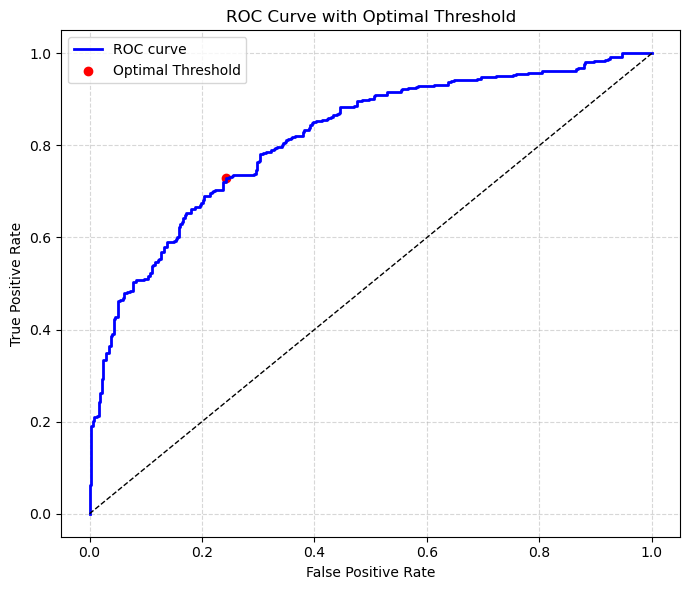

In [98]:


#ROC Curve and optimal theshold
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve")
plt.scatter(fpr[youden_index], tpr[youden_index], color="red", label="Optimal Threshold")
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.title("ROC Curve with Optimal Threshold")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


Below graph provides the distribution on predicted probabilities and its density with also thresolds

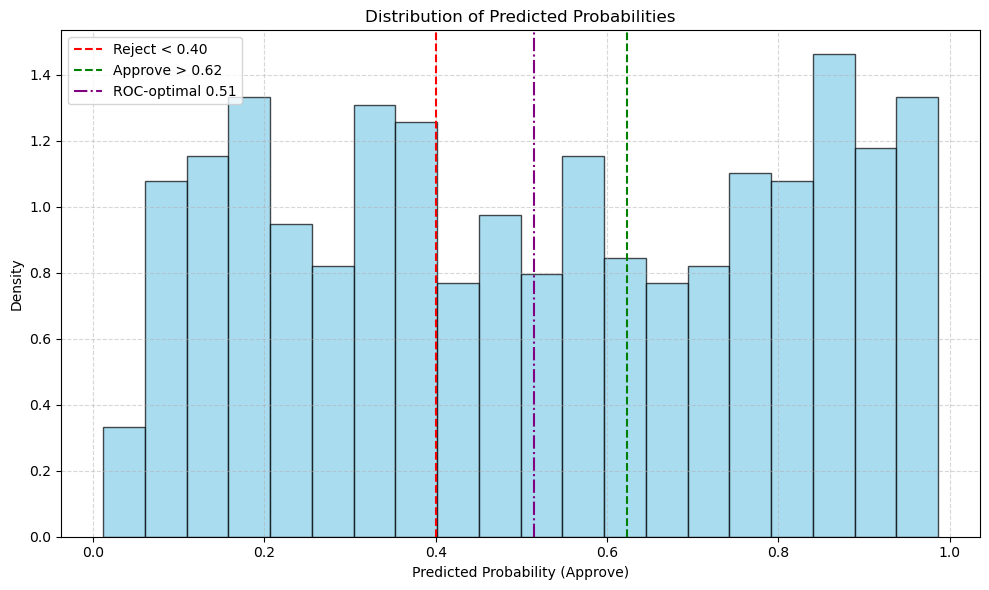

In [99]:

#Probability distribution
plt.figure(figsize=(10, 6))
plt.hist(p, bins=20, density=True, color="skyblue", edgecolor="black", alpha=0.7)
plt.axvline(low_thresh, color="red", linestyle="--", label=f"Reject < {low_thresh:.2f}")
plt.axvline(high_thresh, color="green", linestyle="--", label=f"Approve > {high_thresh:.2f}")
plt.axvline(optimal_thresh, color="purple", linestyle="-.", label=f"ROC-optimal {optimal_thresh:.2f}")
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability (Approve)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()